<img src="images/gradhats.jpg" align='center' alt="Students in cap and gown sitting at graduation" style="width: 800px;"/>

# Technical Overview
Targeting black college graduation rates, this project seeks to answer a regression problem using only financial information from public and private four year colleges in US. Data was clean of Nans by simple imputation. Model Methods included Muliple Linear Regression and Regression Decision Trees, using Lasso, Stepwise, and Random Forest Regression feature selection, along with GridSearchCV hyperparameter tuning. 

# Business Understanding
In [Public Act 102-0570](https://ilga.gov/legislation/publicacts/fulltext.asp?Name=102-0570), Illinois' General Assembly has commissioned the Illinois Board of Higher Education (IBHE) to offer "specific data-driven criteria and approaches to the General Assembly to adequately, equitably, and stably fund public universities in this State and to evaluate existing funding methods." This Commision on Equitable Public University Funding (CEPUF) coincides with the [A Thriving Illinois: Higher Education Paths to Equity, Sustainability, and Growth] (https://ibhestrategicplan.ibhe.org/IBHE-Strategic-Plan-2021.html) which includes providing "equitable funding so that students can receive the best educational experience and succeed at whichever institution they attend," and funding "institutions sufficiently to achieve student, institutional, and state goals."

This project targets 6-year black bachelors graduation rates for first-time, full-time students-- the typical measure for college student success-- using U.S. public and private university data from the Integrated Postsecondary Education Data System (IPEDS). This project aims to offer data-driven advice on how Illinois' universities might better leverage their financials towards black student success.

# Data Understanding
Data was accessed through [IPEDS](https://nces.ed.gov/ipeds/use-the-data/download-access-database). After downloading 10 years(2009-2020) of their Access database files (.accdb), pyodbc module and SQL query was used to pull financial data (financial data (tables: DRVF, F_F1A, and F_F2) from 1681 public (587) and private (1094) universities (The IPEDS website does offer a [user-friendly query interface](https://nces.ed.gov/ipeds/datacenter/InstitutionList.aspx?goToReportId=1), but only 20 variables could be pulled at a time. Also, make sure the features selected are in the years selected, or an error will occur). 

### Imports

In [219]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pyodbc
import matplotlib.pyplot as plt

from functools import reduce

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.dummy import  DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

### Retrieval
Here is an example of a query for the target variable for one of the 10 years of databases:
 
![code](images/retrieval.png)

After the queries were saved to csv, they were concatenated into two datafrrames: public and private. 

![code](images/concatenate.png)

One advantage of IPEDS is that all tables have the same key: 'UNITID' (except for the provisional tables in 2019-2020 DRVC2019, DRVEF122019, DRVF2019, DRVIC2019, S2019_OC have key:'unitid'; S2019_IS and S2019_NH have key:'UnitiID'), which made joining a breeze. Here, now, are the completed dataframes:

In [166]:
df_private = pd.read_csv("data/private_financials_10.csv").iloc[:, 1:]
df_public = pd.read_csv("data/public_financials_10.csv").iloc[:, 1:]

### Labeling
A csv of school IDs and labels pulled from IPEDs for the index, and is merged to the dataframe. Labels for variables were also pulled from the table and variable documentation alongside the acces databases. Labels were transposed over variable names in excel.

In [167]:
#Read school id's
df_ids = pd.read_csv("data/university_ids.csv").iloc[:,0:2]
df_ids.rename(columns={'IPEDS\nUnit ID': 'UNITID', 'Organization or School Name':'School'}, inplace=True)
private_ids = [df_ids, df_private]
public_ids = [df_ids, df_public]
#Add school names
df_private= reduce(lambda x, y: pd.merge(x, y, on = 'UNITID'), private_ids)
df_public= reduce(lambda x, y: pd.merge(x, y, on = 'UNITID'), public_ids)
#Set Index
df_private.set_index(['School'], inplace=True)
df_public.set_index(['School'], inplace=True)

### Limitations
Because IPEDS is institutional in focus, it does not track specific cohorts of students; thus, financial information for individual students, including financial aid, loan default information, and family income are excluded. The target variable in particular only refers to full-time, first-time students, meaning transfers and part-time graduates are out. 

### Data Cleaning
If the school did not have the target variable, it was excluded from the analysis. Sadly, Governors State University, a public school in Illinois, did not have any target information; therefore it was removed.

In [168]:
#Drop schools if they do not have target
df_private = df_private[~df_private['Target'].isna()]
df_public = df_public[~df_public['Target'].isna()]

Some of the financial metrics changed in 2014, so some columns are missin 40% of the data. These columns were the subcategories of Benefits, Operation and maintenance of plant, Depreciation,Interest, All other for several categories, now summarized in 'Total amount' and 'Salaries and wages' for Instruction, Research, Public service, etc. These subcategories were dropped. 

In [169]:
#drop 40% missing columns
num_pr= len(df_private) * .40
res = df_private.columns[df_private.isnull().sum() > num_pr]
df_private.drop(res, inplace=True, axis=1)

num_pub = len(df_public) * .40
res2 = df_public.columns[df_public.isnull().sum() > num_pub]
df_public.drop(res2, inplace=True, axis=1)

### EDA
First, Illinois schools need to be sliced from the public and private dataframes

In [170]:
#Slicing Illinois Private Schools
illinois_private = pd.read_csv("data/IL_private_schools.csv")
il_ids_pr=illinois_private["UnitID"].tolist()
illinois_pr = df_private[df_private["UNITID"].isin(il_ids_pr)]

In [171]:
#Slicing Illinois Public Schools
illinois_public = pd.read_csv("data/IL_public_schools.csv")
il_ids_pub=illinois_public["UnitID"].tolist()
illinois_pub = df_public[df_public["UNITID"].isin(il_ids_pub)]

#### Groupby school, year, and school and year for the Public and Private datasets, along with the subset of Illinois schools. 

In [172]:
#All private schools
private_schools= df_private.groupby("UNITID").mean()
private_byyear = df_private.groupby('Year').mean()
private_school_and_year = df_private.groupby(['UNITID', 'Year']).mean()
#All public schools
public_schools= df_public.groupby("UNITID").mean()
public_byyear = df_public.groupby('Year').mean()
public_school_and_year = df_public.groupby(['UNITID', 'Year']).mean()
# Illinois private schools
il_pr_schools= illinois_pr.groupby("UNITID").mean()
il_pr_byyear = illinois_pr.groupby('Year').mean()
il_pr_school_and_year = illinois_pr.groupby(['UNITID', 'Year']).mean()
#Illinois public schools
il_pub_schools= illinois_pub.groupby("UNITID").mean()
il_pub_byyear = illinois_pub.groupby('Year').mean()
il_pub_school_and_year = illinois_pub.groupby(['UNITID', 'Year']).mean()

### Illinois schools Black Graduation Rates
Illinois' public uniersities graduation rates vary from 8% at Northern Illinois University to 73% at University of Illinois. 


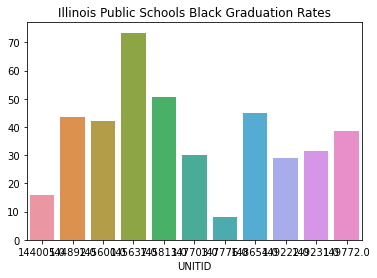

In [178]:
y =il_pub_schools['Target'].values
X = il_pub_schools['Target'].index
sns.barplot(X,y).set(title='Illinois Public Schools Black Graduation Rates');

### Black Graduation Rates over time
American public institutions of higher education are increasing black graduation rates. 

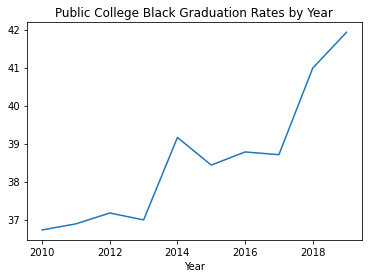

In [179]:
y =public_byyear['Target'].values
X = public_byyear['Target'].index
sns.lineplot(X,y).set(title='Public College Black Graduation Rates by Year');

But Illinois schools are trending in the opposite direction...

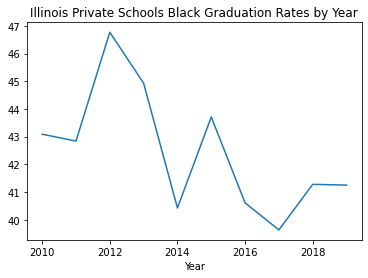

In [180]:
y =il_pr_byyear['Target'].values
X = il_pr_byyear['Target'].index
sns.lineplot(X,y).set(title='Illinois Private Schools Black Graduation Rates by Year');

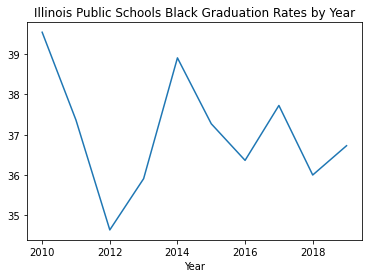

In [181]:
y =il_pub_byyear['Target'].values
X = il_pub_byyear['Target'].index
sns.lineplot(X,y).set(title='Illinois Public Schools Black Graduation Rates by Year');

### Train, Test, Split

In [182]:
#private
y_pr = df_private['Target']
X_pr = df_private.drop(columns = ['Target'], axis = 1)
X_train_pr, X_test_pr, y_train_pr, y_test_pr = train_test_split(X_pr,
                                             y_pr, random_state = 42)
#and for public
y_pub = df_public['Target']
X_pub = df_public.drop(columns = ['Target'], axis = 1)
X_train_pub, X_test_pub, y_train_pub, y_test_pub = train_test_split(X_pub, 
                                            y_pub, random_state = 42)


# Methods
Because the Illinois Board of Higher Educatoni is seeking specific policy advice, this project will avoid black-box and hard-to-interpret models. The approach is simple, starting with a baseline, iterate through Linear Regressions and Decision Tree Regressions to find the best model. 

### Pipeline
Missing values (just not from the 40% missing columns), will be imputed. And due to the high variance between financial variables, they will be standardized. 

In [183]:
pipeline = Pipeline(steps=[
    ('si', SimpleImputer()),
    ('ss', StandardScaler())
])


### Baseline
A simple dummy regressor that guesses the mean. Notice the R^2 of 0.

In [184]:
dummy_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('dummy', DummyRegressor())
])
#Fit model
dummy_pr.fit(X_train_pr, y_train_pr)

#Grab predictions
dummy_pr_preds= dummy_pr.predict(X_train_pr)

#R^2 score
dummy_pr_score = dummy_pr.score(X_train_pr, y_train_pr)
print("Dummy PR R^2 Training Score:" + str(dummy_pr_score))

#Run a cross validation to test for overfitting
dummy_pr_v= np.mean(cross_val_score(dummy_pr, X_train_pr, y_train_pr, cv=5))
print("Dummy PR R^2 Validation Score:" + str(dummy_pr_v))

#RMSE
dummy_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,dummy_pr_preds))
print('Dummy PR Root Mean Squared Error:' + str(dummy_pr_rmse))

Dummy PR R^2 Training Score:0.0
Dummy PR R^2 Validation Score:-0.0005092556664282544
Dummy PR Root Mean Squared Error:26.991139559568747


In [185]:
#Public
dummy_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('dummy', DummyRegressor())
])
dummy_pub.fit(X_train_pub, y_train_pub)
dummy_pub_preds =dummy_pub.predict(X_train_pub)
dummy_pub_score = dummy_pub.score(X_train_pub, y_train_pub)
print("Dummy PUB R^2 Training Score:" + str(dummy_pub_score))
dummy_pub_v= np.mean(cross_val_score(dummy_pr, X_train_pub, y_train_pub, cv=5))
print("Dummy PUB R^2 Validation Score:" + str(dummy_pub_v))
dummy_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,dummy_pub_preds))
print('Dummy PUB Root Mean Squared Error:' +str(dummy_pub_rmse))

Dummy PUB R^2 Training Score:0.0
Dummy PUB R^2 Validation Score:-0.000665679256072016
Dummy PUB Root Mean Squared Error:20.67988980644399


### Multiple Linear Regression with Lasso
In order to pair down the large amount of feautres, L1 (Lasso) selection will penalize the less impactful coefficients. 

In [186]:
#Private
lr_pr = Pipeline(steps=[
    ('pipe', pipeline),
    ('selection', SelectFromModel(Lasso())),
    ('ols', LinearRegression(normalize=True))
])
lr_pr.fit(X_train_pr, y_train_pr)
y_pred_lr_pr = lr_pr.predict(X_train_pr)
lr_pr_score=lr_pr.score(X_train_pr, y_train_pr)
print("LR PR R^2 Training Score:" + str(lr_pr_score))
lr_pr_v=scores_pr= np.mean(cross_val_score(lr_pr, X_train_pr, y_train_pr, cv=5))
print("LR PR R^2 Validation Score:" + str(lr_pr_v))
lr_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,y_pred_lr_pr))
print('LR PR Root Mean Squared Error:' +str(lr_pr_rmse))

LR PR R^2 Training Score:0.3499213144148585
LR PR R^2 Validation Score:0.34399500980911224
LR PR Root Mean Squared Error:21.76226949838226


In [187]:
#for public
lr_pub = Pipeline(steps=[
    ('pipe', pipeline),
    ('selection', SelectFromModel(Lasso())),
    ('ols', LinearRegression(normalize=True))
])
lr_pub.fit(X_train_pub, y_train_pub)
y_pred_lr_pub = lr_pub.predict(X_train_pub)
lr_pub_score= lr_pub.score(X_train_pub, y_train_pub)
print("LR PUB R^2 Score:" + str(lr_pub_score))
lr_pub_v = np.mean(cross_val_score(lr_pub, X_train_pub, y_train_pub, cv=5))
print("LR PUB R^2 Validation Score:" + str(lr_pub_v))
lr_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,y_pred_lr_pub))
print('LR PUB Root Mean Squared Error:' + str(lr_pub_rmse))


LR PUB R^2 Score:0.3821655228453187
LR PUB R^2 Validation Score:0.36840659917478996
LR PUB Root Mean Squared Error:16.254899552578653


In [221]:
#Feature Coefficients
important_private = []
for name, coef in zip(X_train_pr.columns, lr_pr['ols'].coef_):
    important_private.append((name, coef))
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[:10])
#lowest coefficients for public
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[-10:])

[('Total Plant, Property, and Equipment', 6.16868228084869), ('Construction in Progress', 5.5685385010960555), ('Land  improvements - End of year', 2.671442498283658), ('Total unrestricted net assets', 2.5698869488198626), ('Debt related to Property, Plant, and Equipment', 2.5491811179617354), ('Permanently restricted net assets included in total restricted net assets', 1.997659952639527), ('Equipment, including art and library collections - End of year', 1.5776826297644775), ('Temporarily restricted net assets', 1.3016528723696075), ('Total restricted net assets', 1.1606734386714712), ('Total assets', 1.053445866102086)]
[('Temporarily restricted net assets', 1.3016528723696075), ('Total restricted net assets', 1.1606734386714712), ('Total assets', 1.053445866102086), ('UNITID', 0.1439592992612296), ('Buildings - End of year', -0.877413259820085), ('Accumulated depreciation', -0.8955504116293498), ('Total liabilities', -1.3376852502153376), ('Property, Plant, and Equipment, net of acc

In [ ]:
#Feature Coefficients
important_private = []
for name, coef in zip(X_train_pub.columns, lr_pub['ols'].coef_):
    important_private.append((name, coef))
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[:10])
#lowest coefficients for public
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[-10:])

### SelectFromModel Decision Trees
I optimized a random forest with grid search for the best r^2 and lowest RMSE. Then, I used this forest to select features for the decision tree, which was then also gridsearched (example below).

In [205]:
#Private
tree_pr=Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(max_features=24, n_estimators=100, max_depth=7, 
                                    min_samples_split=.1, min_samples_leaf=.1))),
    ('tree', DecisionTreeRegressor(max_depth=4, min_samples_split=.01, min_samples_leaf=.1,
     max_features=24, random_state=42))
])
tree_pr.fit(X_train_pr, y_train_pr)
tree_pr_preds =tree_pr.predict(X_train_pr)
tree_pr_score= tree_pr.score(X_train_pr, y_train_pr)
print("Tree PR R^2:" + str(tree_pr_score))
tree_pr_v = np.mean(cross_val_score(tree_pr, X_train_pr, y_train_pr, cv=5))
print("Tree PR R^2 Validation Score:" + str(tree_pr_v))
tree_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,tree_pr_preds))
print('Tree PR Root Mean Squared Error:' +str(tree_pr_rmse))

Tree PR R^2:0.3854600914296248
Tree PR R^2 Validation Score:0.3753189333418302
Tree PR Root Mean Squared Error:21.15905495300064


In [206]:
tree_pub= Pipeline(steps=[
    ('pipe', pipeline),
    ('sel', SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6))),
    ('tree', DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 0.05, min_samples_split= 0.15,
    max_features=18,random_state=42))
])
tree_pub.fit(X_train_pub, y_train_pub)
tree_pub_preds =tree_pub.predict(X_train_pub)
tree_pub_score= tree_pub.score(X_train_pub, y_train_pub)
print("Tree PUB R^2:" + str(tree_pub_score))
tree_pub_v = np.mean(cross_val_score(tree_pub, X_train_pub, y_train_pub, cv=5))
print("Tree PUB R^2 Validation Score:" + str(tree_pub_v))
tree_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,tree_pub_preds))
print('Tree PUB Root Mean Squared Error:' + str(tree_pub_rmse))

Tree PUB R^2:0.4165381860063039
Tree PUB R^2 Validation Score:0.35983841908187486
Tree PUB Root Mean Squared Error:15.796266030275119


Again code inserted here to save some time running the gridsearch. 

![gscv_pr](images/gridsearch_pr.png)


![gscv_pub](images/gridsearch_pub.png)

### Unscaled Linear Regression
Since private schools scored best on the Linear Ression, the variables will be unscaled for interpretation. 

In [222]:
pipeline2 = Pipeline(steps=[
    ('si', SimpleImputer()),
])
#Private
lr_pr_2 = Pipeline(steps=[
    ('pipe', pipeline2),
    ('selection', SelectFromModel(Lasso())),
    ('ols', LinearRegression(normalize=True))
])
lr_pr_2.fit(X_train_pr, y_train_pr)
y_pred_lr_pr = lr_pr_2.predict(X_train_pr)
lr_pr_score=lr_pr_2.score(X_train_pr, y_train_pr)
print("LR PR R^2 Training Score:" + str(lr_pr_score))
lr_pr_v=scores_pr= np.mean(cross_val_score(lr_pr_2, X_train_pr, y_train_pr, cv=5))
print("LR PR R^2 Validation Score:" + str(lr_pr_v))
lr_pr_rmse = np.sqrt(mean_squared_error(y_train_pr,y_pred_lr_pr))
print('LR PR Root Mean Squared Error:' +str(lr_pr_rmse))

LR PR R^2 Training Score:0.33303461006142876
LR PR R^2 Validation Score:0.07921410032444587
LR PR Root Mean Squared Error:22.043110099147718


In [225]:
#Feature Coefficients
important_private = []
for name, coef in zip(X_train_pr.columns, lr_pr_2['ols'].coef_):
    important_private.append((name, coef))
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[:5])
#lowest coefficients for public
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[-3:])

[('Equipment, including art and library collections - End of year', 0.2406053595991174), ('Intangible Assets, net of accumulated amortization', 0.17883127699817675), ('Total Plant, Property, and Equipment', 0.17048682406157353), ('Total assets', 0.1473797636848417), ('Temporarily restricted net assets', 0.050726804946550776)]
[('Net assets, beginning of the year', -0.09532234265354012), ('Other specific changes in net assets', -0.31209272002369404), ('Adjustments to beginning of year net assets', -0.45331002610265125)]


### Separate Trees for plotting
Because the Tree did better with Public Schools, the model is duplicated outside the pipeline in order to plot the tree. 

In [209]:
si= SimpleImputer()
X_train_pub_imputed= si.fit_transform(X_train_pub)
X_train_pub_imputed=pd.DataFrame(X_train_pub_imputed, 
    index=X_train_pub.index, columns=X_train_pub.columns)
#feature Selection
sel_pub= SelectFromModel(RandomForestRegressor(min_samples_leaf=.1, min_samples_split =.1,
                                      max_features=22, n_estimators=100,max_depth=6, random_state=42))
sel_pub.fit(X_train_pub_imputed, y_train_pub)
selected_feat_pub= X_train_pub_imputed.columns[(sel_pub.get_support())]
selected_feat_pub = selected_feat_pub.tolist()
X_train_pub_sel=X_train_pub_imputed[selected_feat_pub]

In [210]:
separate_tree_pub= DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 0.05, min_samples_split= 0.15,
    max_features=14,random_state=42)

separate_tree_pub.fit(X_train_pub_sel, y_train_pub)
separate_tree_pub_preds =separate_tree_pub.predict(X_train_pub_sel)

separate_tree_pub_score= separate_tree_pub.score(X_train_pub_sel, y_train_pub)
print("Tree PUB R^2:" + str(separate_tree_pub_score))

separate_tree_pub_v = np.mean(cross_val_score(separate_tree_pub, X_train_pub_sel, y_train_pub, cv=5))
print("Tree PUB R^2 Validation Score:" + str(separate_tree_pub_v))

separate_tree_pub_rmse = np.sqrt(mean_squared_error(y_train_pub,separate_tree_pub_preds))
print('Tree PUB Root Mean Squared Error:' + str(separate_tree_pub_rmse))

Tree PUB R^2:0.4105352114983639
Tree PUB R^2 Validation Score:0.3780604707591819
Tree PUB Root Mean Squared Error:15.877318401585056


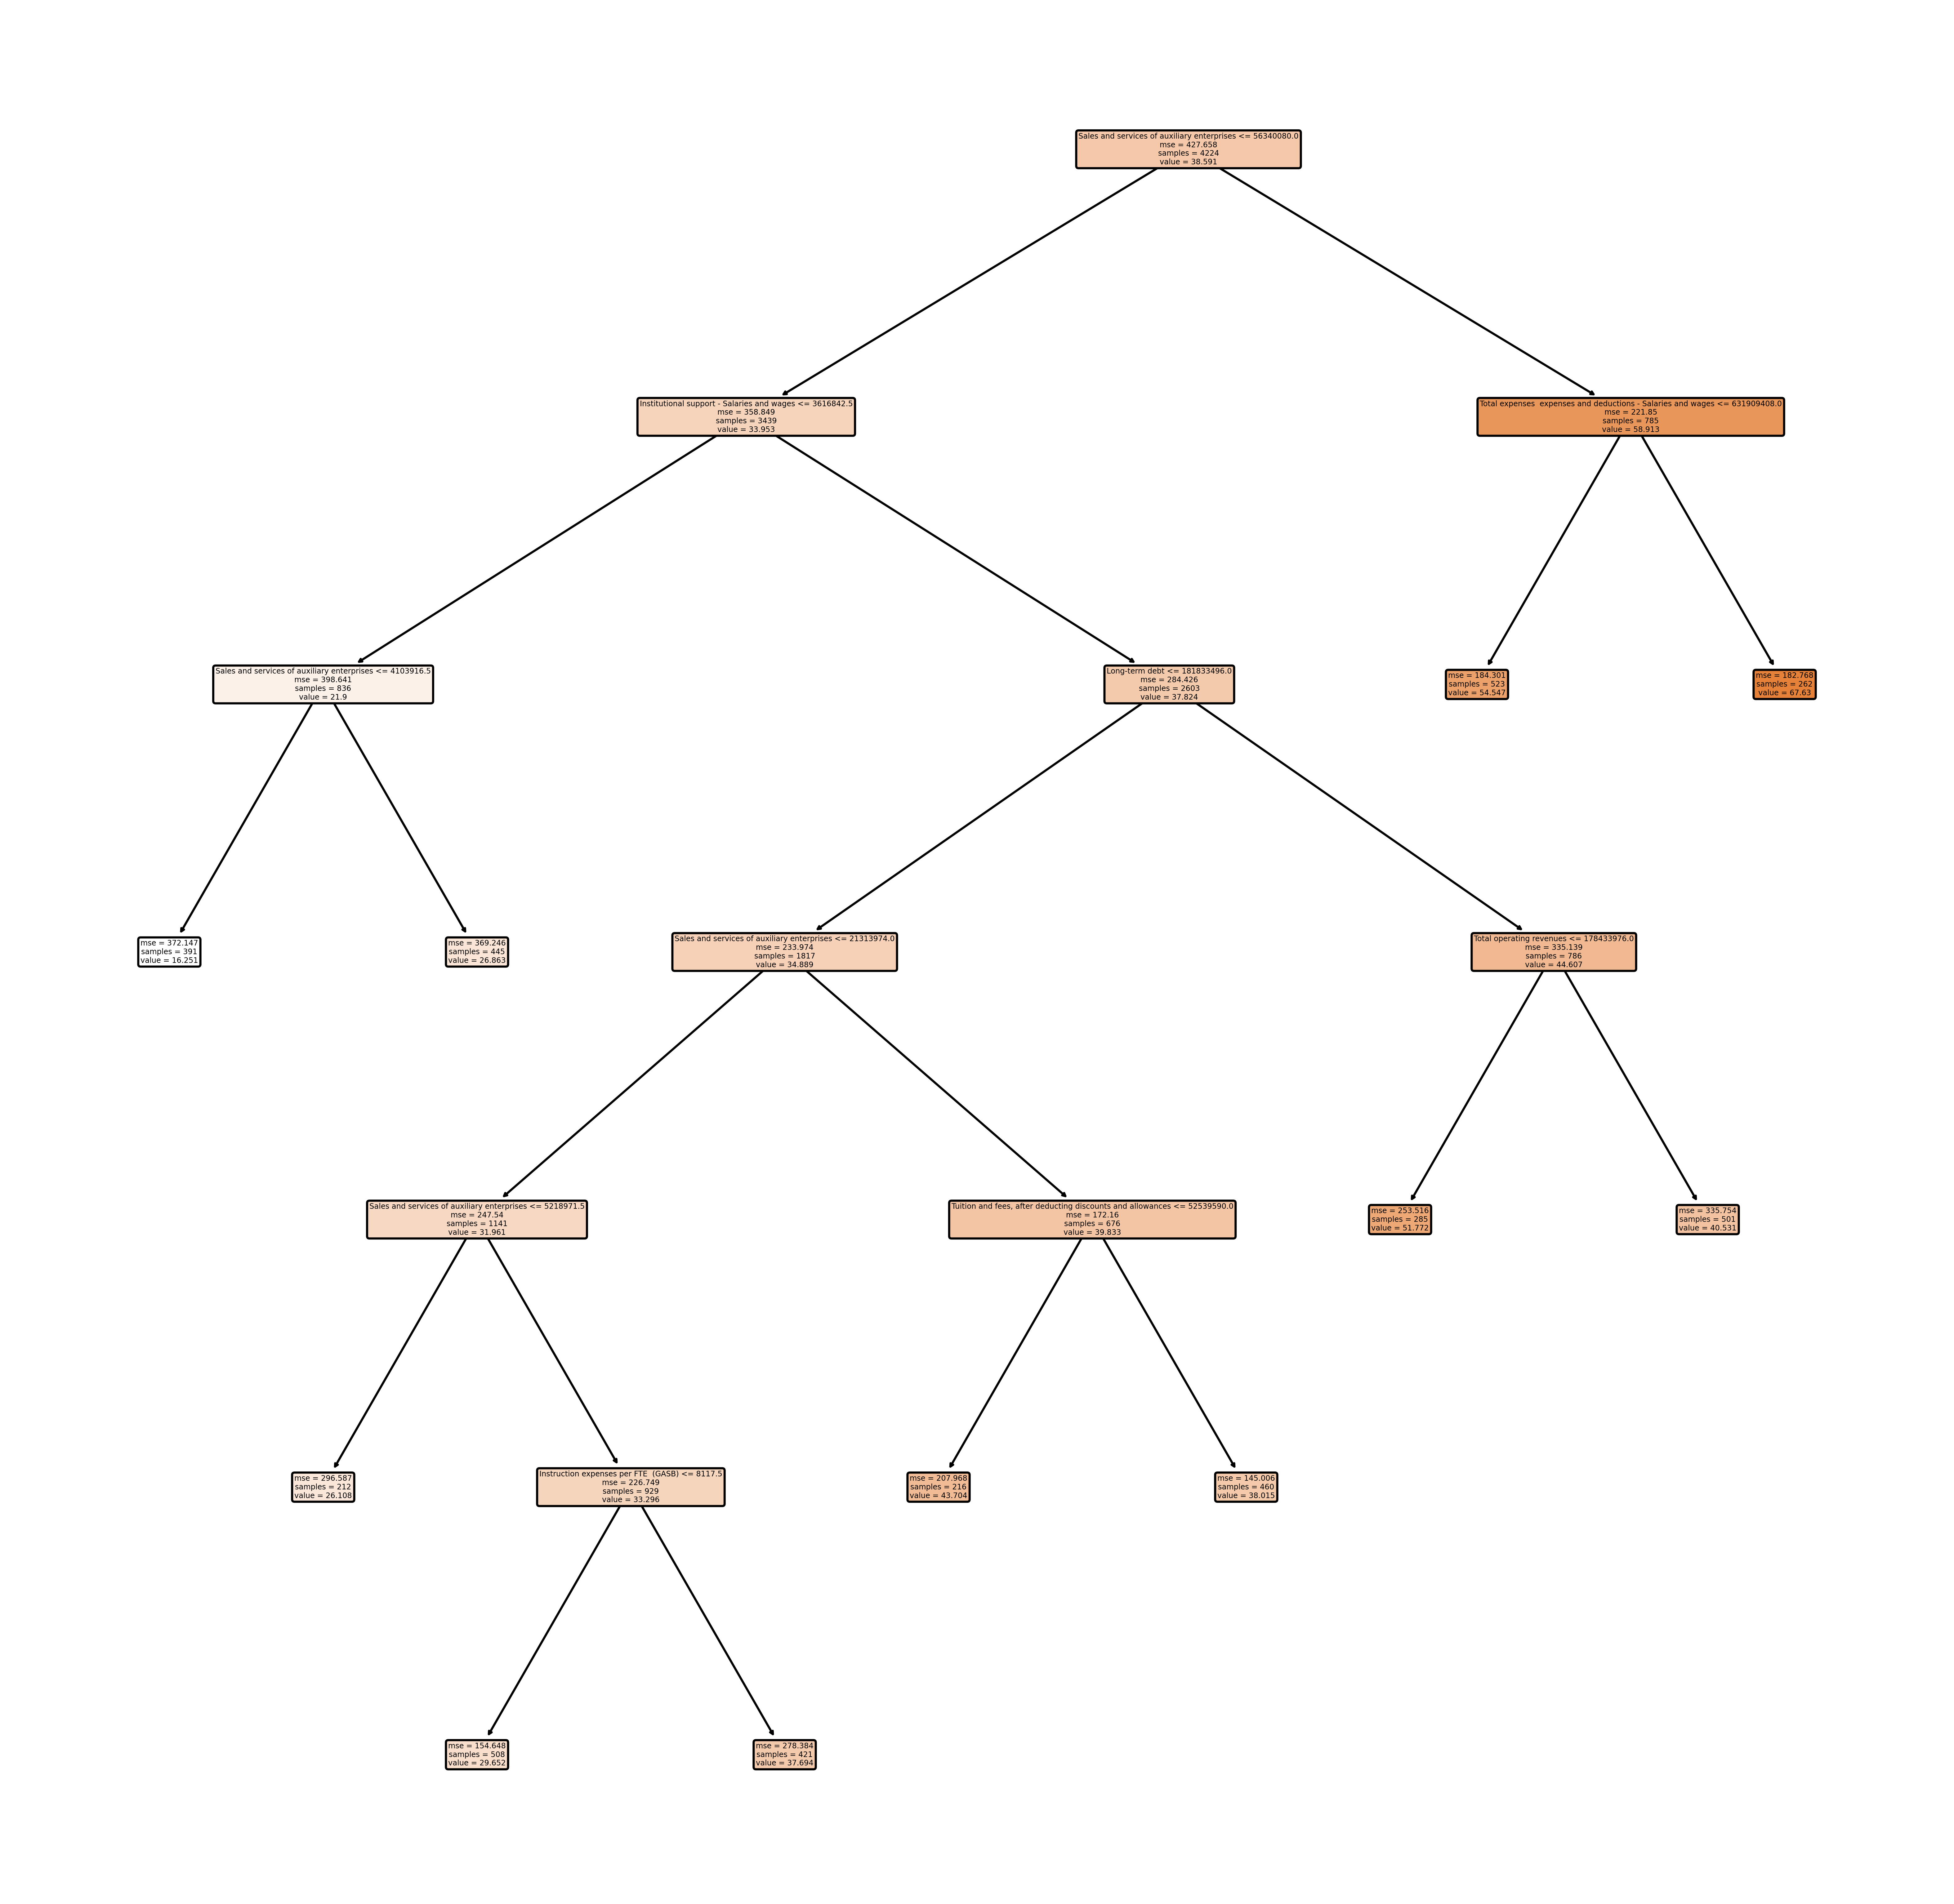

In [220]:
# Plot and show decision tree
plt.figure(figsize=(16,16), dpi=500)
plot_tree(separate_tree_pub, 
               feature_names=X_train_pub_sel.columns,
               class_names=np.unique(y_train_pub).astype('str'),
               filled=True, rounded=True)
plt.show()


# Evaluation
The Random Forest model performed best, but as stated earlier, this model is hard to interpret. So, the next best model for Public and private schools was a decision tree with random forest selection.

#### Preprocessing

In [213]:
#Private
si=SimpleImputer()
X_test_pr_imputed= si.fit_transform(X_test_pr, y_test_pr)
X_test_pr_imputed=pd.DataFrame(X_test_pr_imputed, 
    index=X_test_pr.index, columns=X_test_pr.columns)

In [214]:
#Public
si = SimpleImputer()
X_test_pub_imputed= si.fit_transform(X_test_pub, y_test_pub)
X_test_pub_imputed=pd.DataFrame(X_test_pub_imputed, 
    index=X_test_pub.index, columns=X_test_pub.columns)
X_test_pub_sel=X_test_pub_imputed[selected_feat_pub]

#### Scores

In [226]:
#private
lr_2_pr_preds =lr_pr_2.predict(X_test_pr_imputed)
lr_2_pr_score= lr_pr_2.score(X_test_pr_imputed, y_test_pr)
print("Test LR PR R^2:" + str(lr_2_pr_score))
lr_2_pr_rmse = np.sqrt(mean_squared_error(y_test_pr,lr_2_pr_preds))
print('Test LR PR Root Mean Squared Error:' +str(lr_2_pr_rmse))

Test LR PR R^2:0.31202383351866114
Test LR PR Root Mean Squared Error:22.06807076117998


In [216]:
#Public
separate_tree_pub_preds =separate_tree_pub.predict(X_test_pub_sel)
separate_tree_pub_score= separate_tree_pub.score(X_test_pub_sel, y_test_pub)
print("Test Tree PUB R^2:" + str(separate_tree_pub_score))
separate_tree_pub_rmse = np.sqrt(mean_squared_error(y_test_pub,separate_tree_pub_preds))
print('Test Tree PUB Root Mean Squared Error:' + str(separate_tree_pub_rmse))

Test Tree PUB R^2:0.34471562987765947
Test Tree PUB Root Mean Squared Error:16.815444821735156


#### Feature Importance
For Private Universities, it seems that asset allocation plays a large part in black graduation rates.

In [227]:
#Feature Coefficients
important_private = []
for name, coef in zip(X_train_pr.columns, lr_pr_2['ols'].coef_):
    important_private.append((name, coef))
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[:5])
#lowest coefficients for public
print(sorted(important_private, key=lambda tup: tup[1], reverse=True)[-3:])

[('Equipment, including art and library collections - End of year', 0.2406053595991174), ('Intangible Assets, net of accumulated amortization', 0.17883127699817675), ('Total Plant, Property, and Equipment', 0.17048682406157353), ('Total assets', 0.1473797636848417), ('Temporarily restricted net assets', 0.050726804946550776)]
[('Net assets, beginning of the year', -0.09532234265354012), ('Other specific changes in net assets', -0.31209272002369404), ('Adjustments to beginning of year net assets', -0.45331002610265125)]


For public universities, auxiliary enterprises, such as dining, housing, bookstores, etc. indicate a school with enough wealth to put it in needed places. Institutional support indicates a need for more planning and operations help. Unsurprising debt and revenue are important for any business to function. 

In [228]:
#Feature importance for Public
important_public = []
names_public = []
for name, importance in zip(X_train_pub_sel.columns, separate_tree_pub.feature_importances_):
    if importance > 0:
        important_public.append((name, importance))
        names_public.append(name)
print(sorted(important_public, key=lambda tup: tup[1], reverse=True)[:10])

[('Sales and services of auxiliary enterprises', 0.6160413774096438), ('Institutional support - Salaries and wages', 0.21636632609449716), ('Long-term debt', 0.06986198774661001), ('Total expenses  expenses and deductions - Salaries and wages', 0.040287685862917894), ('Total operating revenues', 0.0309526995207528), ('Instruction expenses per FTE  (GASB)', 0.020076534709307346), ('Tuition and fees, after deducting discounts and allowances', 0.0064133886562708665)]


# Recommendations
1) Focus on NIU and CSU. Because their graduation rates are so low (8% and 16%), marginal improvments will make the largest difference. For example, if given the current enrollment at NIU and successful changes to increase graduation rates to match the average of illinois (37%), an additional 600 black students would have degrees. This would in turn lead to an 11% in the states overall black student graduation rate. 
2) Incentivize discounts on sales and services of auxiliary enterprises, which may help supplement the non-tiution related costs of attending school. 
3) Encourage public schools to hire more institutional support, as it is the third most important feature for public schools. This means better management, operations, and fundraising efforts. 
4) Private schools seems to be about accumulating assets like books in libraries, art, equipment, and property. This likely is just a reflection of wealthy schools doing well, not a direct causal link.

# Next Steps
- Given more time with the data, this project would calculate the rate of change for these features and run a time series model to see if a given lag year for a student is of importance for graduating. 
- The graduation rate for IPEDS only calculates first time, full-time students, which excludes transfers,  winter enrollment, and part-timers, possibly [up to 50% of students](), so expanding the target to include these students would give a more accurate protrayal of student success. I would also like to track the 10 year default rate on loans for Illinois schools, as the debt places an already disproportional burden on minority communities. 
- Finally, I am willing to consider optimal financial aid rates, which furthers your goal towards equity and sustainability. 